# Импорт

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
f_name = 'Camera 3_20220526_003249.mp4'
img_shape = (119,119)
xmin,ymin = 115, 210
xmax, ymax = 350, 445

# Собираем кадры из видео

In [3]:
if not os.path.isdir('data'):
    count = 0
    os.mkdir('data')
    cap = cv2.VideoCapture(f_name)

    while cap.isOpened():
        ret, frame = cap.read()

        if ret:
            frame = frame[ymin:ymax, xmin:xmax]
            frame = cv2.resize(frame, img_shape)
            cv2.imwrite(f'data/frame{count}.jpg', frame)
            count += 15 
            cap.set(cv2.CAP_PROP_POS_FRAMES, count)
        else:
            cap.release()
            break
else:
    print('Директория с данными уже существует')

Директория с данными уже существует


In [4]:
with_worker_size = len(os.listdir('data/with_worker'))
without_worker_size = len(os.listdir('data/without_worker'))
print(f'Количество кадров с работником {with_worker_size}')
print(f'Количество кадров без работника {without_worker_size}')

Количество кадров с работником 8785
Количество кадров без работника 28899


# Создаем датасеты

In [5]:
# Наблюдается дисбаланс по классам, поэтому возьмем только часть изображений, где работник отсутсвует
with_worker_paths = []
without_worker_paths = []

for name in os.listdir('data/with_worker'):
    with_worker_paths.append(f'data/with_worker/{name}')

for name in os.listdir('data/without_worker')[::3]:
    without_worker_paths.append(f'data/without_worker/{name}')
print(f'Количество кадров с работником {len(with_worker_paths)}')
print(f'Количество кадров без работника {len(without_worker_paths)}')

Количество кадров с работником 8785
Количество кадров без работника 9633


In [6]:
paths = with_worker_paths + without_worker_paths
labels = [1] * len(with_worker_paths) + [0] * len(without_worker_paths)
df = pd.DataFrame({'path':paths, 'label':labels})
df = df.sample(frac=1).reset_index(drop=True)
df

,path,label
0,data/with_worker/frame159240.jpg,1
1,data/without_worker/frame499800.jpg,0
2,data/with_worker/frame298365.jpg,1
3,data/without_worker/frame401985.jpg,0
4,data/without_worker/frame261630.jpg,0
...,...,...
18413,data/with_worker/frame158715.jpg,1
18414,data/with_worker/frame298695.jpg,1
18415,data/without_worker/frame461385.jpg,0
18416,data/without_worker/frame65940.jpg,0


In [7]:
train_df = df[:int(0.8 * df.shape[0])]
val_df = df[int(0.8 * df.shape[0]):int(0.9 * df.shape[0])]
test_df = df[int(0.9 * df.shape[0]):]
print(f'train size {train_df.shape[0]}')
print(f'val size {val_df.shape[0]}')
print(f'test size {test_df.shape[0]}')

train size 14734
val size 1842
test size 1842


In [8]:
def preprocess_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Добавим аугментацию изображеий, так как их не очень много, и они похожи друг на друга
def data_aug(img):
    if tf.random.uniform(())>0.5:
        img = tf.image.random_brightness(img, max_delta=0.05, seed=42)
    if tf.random.uniform(())>0.5:
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2, seed=42)
        
        
    return img

In [9]:
batch_size = 64

train_imgs = tf.data.Dataset.from_tensor_slices(train_df['path'].values)
train_imgs = train_imgs.map(preprocess_img)
train_imgs = train_imgs.map(data_aug)
labels = tf.data.Dataset.from_tensor_slices(train_df['label'].values)

train_ds = tf.data.Dataset.zip((train_imgs, labels))
train_ds = train_ds.shuffle(10000).batch(batch_size)

val_imgs = tf.data.Dataset.from_tensor_slices(val_df['path'].values)
val_imgs = val_imgs.map(preprocess_img)
val_labels = tf.data.Dataset.from_tensor_slices(val_df['label'].values)

val_ds = tf.data.Dataset.zip((val_imgs, val_labels))
val_ds = val_ds.shuffle(10000).batch(batch_size)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


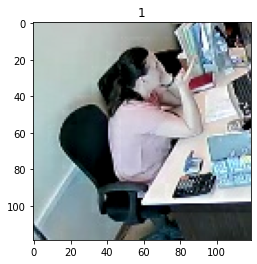

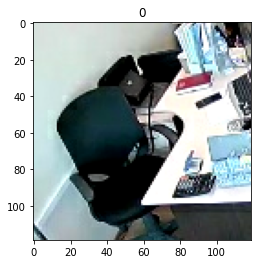

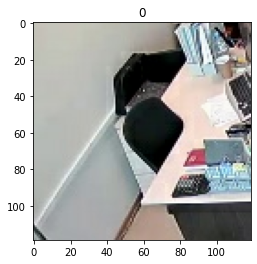

In [10]:
# Визуализируем несколько сэмплов
sample = next(iter(train_ds))
sample_imgs, sample_labels = sample
for img, label in zip(sample_imgs[:3], sample_labels[:3]):
    plt.figure()
    plt.imshow(img)
    plt.title(str(label.numpy()))
    

# Создаем и тренируем модель
### Для уменьшения количесва весов модели, вместо свертки с ядром (n,n) будем использовать две свертки подряд с ядрами (n,1) и (1,n). 

In [11]:
def conv_block(x, num_filters):
    x = layers.Conv2D(num_filters, (1,1))(x)
    x = layers.Conv2D(num_filters, (3,1))(x)
    x = layers.Conv2D(num_filters, (1,3))(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_filters, (3,1), (2,1))(x)
    x = layers.Conv2D(num_filters, (1,3), (1,2))(x)
    x = layers.ReLU()(x)
    return x

img = keras.Input(img_shape + (3,))
x = layers.Conv2D(8, (3,3), activation='relu')(img)
x = layers.MaxPool2D()(x)
# x = conv_block(img, 8)
x = conv_block(x, 16)
x = conv_block(x, 32)
x = conv_block(x, 32)
x = layers.Flatten()(x)
out = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(img, out)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 119, 119, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 117, 117, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 58, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        144       
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 58, 16)        784       
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 16)        784       
                                                             

In [12]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])
model.fit(train_ds,
         epochs=5,
         validation_data=val_ds)

Epoch 1/5
231/231 [==============================] - 18s 50ms/step - loss: 0.0519 - accuracy: 0.9853 - val_loss: 0.0085 - val_accuracy: 0.9957
Epoch 2/5
231/231 [==============================] - 13s 48ms/step - loss: 0.0132 - accuracy: 0.9970 - val_loss: 0.0117 - val_accuracy: 0.9984
Epoch 3/5
231/231 [==============================] - 14s 49ms/step - loss: 0.0095 - accuracy: 0.9980 - val_loss: 0.0050 - val_accuracy: 0.9989
Epoch 4/5
231/231 [==============================] - 14s 49ms/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.0116 - val_accuracy: 0.9978
Epoch 5/5
231/231 [==============================] - 14s 50ms/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.0087 - val_accuracy: 0.9978


In [13]:
model.save('keras_model')

INFO:tensorflow:Assets written to: keras_model\assets


# Посмотрим на результаты на тестовом наборе данных

In [14]:
model = keras.models.load_model('keras_model')

In [15]:
def visualize_predictions(img, label):
    plt.figure(figsize=(7,7))
    if label>0.5:
        title = 'Работник на месте'
    else:
        title = 'Работник отсутсвует'
    plt.imshow(img)
    plt.title(title)

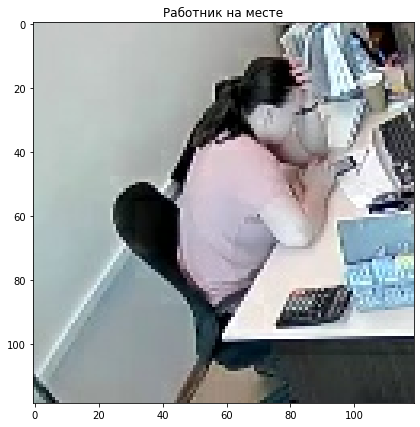

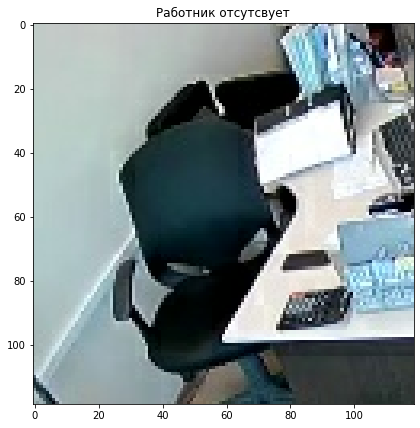

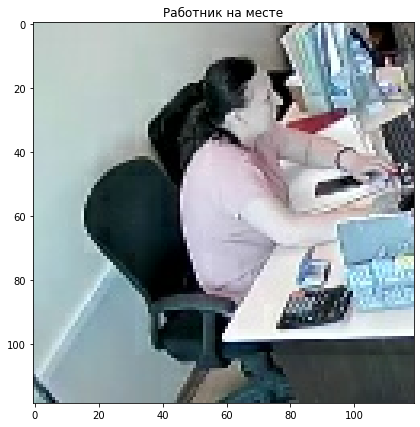

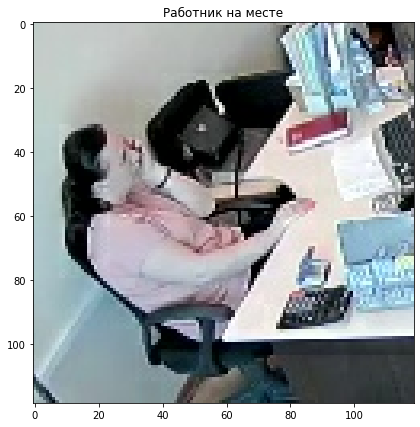

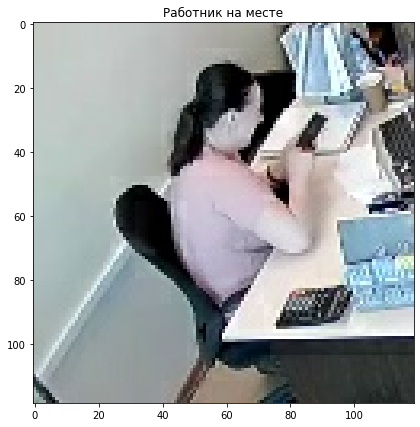

In [16]:
for _ in range(5):
    path = np.random.choice(test_df['path'].values)
    img = preprocess_img(path)
    label = model.predict(img[np.newaxis, :])[0]
    visualize_predictions(img, label)

# Применение модели к видео

In [17]:
# нажать q для выхода их просмотра видео
# l для перемотки вперед
# j для перемотки назад

def callback(x):
    pass

cap = cv2.VideoCapture(f_name)
fps = cap.get(cv2.CAP_PROP_FPS)
skip_seconds = 60


while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        roi_frame = frame[ymin:ymax, xmin:xmax]
        roi_frame = cv2.resize(roi_frame, img_shape)
#         print(roi_frame.shape)
        roi_frame = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2RGB)
        roi_frame = roi_frame / 255.0
        label = model.predict(roi_frame[np.newaxis, :])[0]
        
        if label > 0.5:
            color = (0,255,0)
            text = 'На месте'
        else:
            color = (0,0,255)
            text = 'Отсутсвует'
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color)
        cv2.putText(frame, text, (xmin,ymin), cv2.FONT_HERSHEY_COMPLEX, 1, color)
        cv2.imshow('Monitor', frame)
#         cap.set(cv2.CAP_PROP_POS_FRAMES, count)
        cv2.waitKey(1)
        
        if cv2.waitKey(5) & 0xFF == ord('l'):
            cur_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
            cap.set(cv2.CAP_PROP_POS_FRAMES, cur_frame + fps * skip_seconds)
        if cv2.waitKey(5) & 0xFF == ord('j'):
            cur_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
            cap.set(cv2.CAP_PROP_POS_FRAMES, cur_frame - fps * skip_seconds)
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break     
    else:
        break
cap.release()
cv2.destroyAllWindows()